In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch import nn, optim

import torchvision   
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [2]:
# loading datasets
train_data = datasets.ImageFolder(root='C:/Users/malji/Datasets/HW4_Data/classification_data/train_data', 
                                                 transform=torchvision.transforms.ToTensor())

valid_data = datasets.ImageFolder(root='C:/Users/malji/Datasets/HW4_Data/classification_data/val_data', 
                                               transform=torchvision.transforms.ToTensor())

test_data = datasets.ImageFolder(root='C:/Users/malji/Datasets/HW4_Data/classification_data/test_data', 
                                               transform=torchvision.transforms.ToTensor())

In [3]:
# creating dataloaders
BATCH_SIZE = 128

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, 
                                               shuffle=True, num_workers=8)

val_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, 
                                             shuffle=True, num_workers=8)

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, 
                                             shuffle=True, num_workers=8)


In [4]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 380638
Number of validation examples: 8000
Number of testing examples: 8000


In [5]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [6]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

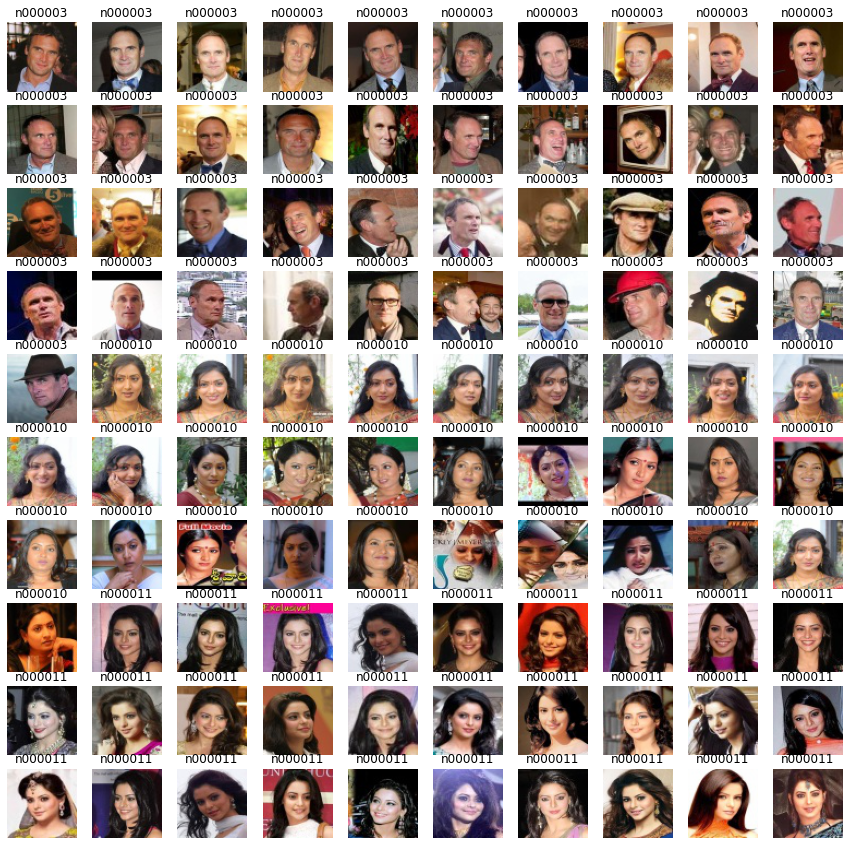

In [7]:
# printing some images and their classes
N_IMAGES = 100

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [8]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [9]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

In [10]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [11]:
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

In [12]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [13]:
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

In [14]:
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight.data)

In [15]:
model = ResNet(resnet18_config, 4000)
model.apply(init_weights)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kerne

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

In [ ]:
START_LR = 1e-1
WEIGHT_DECAY = 1e-4

# optimizer = optim.Adam(model.parameters(), lr=START_LR)

optimizer = optim.SGD(model.parameters(), lr=START_LR, weight_decay=WEIGHT_DECAY, momentum=.9, nesterov=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# device = 'cpu'

print("We are running on ", device)

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [18]:
EPOCHS = 40
STEPS_PER_EPOCH = len(train_dataloader)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [15]:
def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].view(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [16]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [17]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [18]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [23]:
# loading last model uncomment this



# STEPS_PER_EPOCH = len(train_dataloader)
# TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH



# criterion = nn.CrossEntropyLoss()
# model = ResNet(resnet18_config, 4000)
# # optimizer = optim.Adam(model.parameters(),lr=0.003)


# checkpoint = torch.load('C:/Users/malji/Google Drive/Colab Notebooks/trained_model/trained_model_4_2.t7')
# model.load_state_dict(checkpoint['model_state_dict'])

# optimizer = optim.SGD(model.parameters(), lr=START_LR, weight_decay=WEIGHT_DECAY, momentum=.9, nesterov=True)

# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# best_valid_loss = checkpoint['best_valid_loss']
# model = model.to(device)
# criterion = criterion.to(device)

# MAX_LRS = [p['lr'] for p in optimizer.param_groups]
# scheduler = lr_scheduler.OneCycleLR(optimizer,
#                                     max_lr = MAX_LRS,
#                                     total_steps = TOTAL_STEPS)
# # scheduler.load_state_dict(checkpoint['scheduler'])

# for state in optimizer.state.values():
#     for k, v in state.items():
#         if isinstance(v, torch.Tensor):
#             state[k] = v.cuda()



In [24]:
# if you will continue training you should comment next line
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_dataloader, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, val_dataloader, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'C:/Users/malji/Google Drive/Colab Notebooks/trained_model/tut5-model_4_3.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')
    
    start_save_time = time.monotonic()
    torch.save({
            'epoch':epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_valid_loss': best_valid_loss,
            'scheduler': scheduler.state_dict()
            
            }, 'C:/Users/malji/Google Drive/Colab Notebooks/trained_model/trained_model_4_3.t7')
    end_save_time = time.monotonic()

    save_min, save_sec = epoch_time(start_save_time, end_save_time)
    print(f'checkpoint saved in: {save_min}m {save_sec}s')
    end_2 = time.monotonic()

    all_min, all_sec = epoch_time(start_time, end_2)
    print(f'Whole epoch time: {all_min}m {all_sec}s')

Epoch: 01 | Epoch Time: 2m 59s
	Train Loss: 0.014 | Train Acc @1: 100.00% | Train Acc @5: 100.00%
	Valid Loss: 1.719 | Valid Acc @1:  66.06% | Valid Acc @5:  80.92%
checkpoint saved in: 0m 0s
Whole epoch time: 3m 0s
Epoch: 02 | Epoch Time: 3m 0s
	Train Loss: 0.014 | Train Acc @1: 100.00% | Train Acc @5: 100.00%
	Valid Loss: 1.735 | Valid Acc @1:  65.83% | Valid Acc @5:  80.68%
checkpoint saved in: 0m 0s
Whole epoch time: 3m 0s
Epoch: 03 | Epoch Time: 3m 0s
	Train Loss: 0.014 | Train Acc @1: 100.00% | Train Acc @5: 100.00%
	Valid Loss: 1.741 | Valid Acc @1:  65.72% | Valid Acc @5:  80.63%
checkpoint saved in: 0m 0s
Whole epoch time: 3m 0s
Epoch: 04 | Epoch Time: 3m 0s
	Train Loss: 0.014 | Train Acc @1: 100.00% | Train Acc @5: 100.00%
	Valid Loss: 1.723 | Valid Acc @1:  65.99% | Valid Acc @5:  80.82%
checkpoint saved in: 0m 0s
Whole epoch time: 3m 0s
Epoch: 05 | Epoch Time: 3m 1s
	Train Loss: 0.014 | Train Acc @1: 100.00% | Train Acc @5: 100.00%
	Valid Loss: 1.736 | Valid Acc @1:  65.81%

KeyboardInterrupt: ignored

In [19]:
# testing the model
model = ResNet(resnet18_config, 4000)

checkpoint = torch.load('C:/Users/malji/Google Drive/Colab Notebooks/trained_model/trained_model_4_3.t7')
model.load_state_dict(checkpoint['model_state_dict'])
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_dataloader, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

Test Loss: 1.704 | Test Acc @1:  66.60% | Test Acc @5:  81.19%


In [20]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [21]:
images, labels, probs = get_predictions(model, test_dataloader)

In [22]:
pred_labels = torch.argmax(probs, 1)

In [23]:
corrects = torch.eq(labels, pred_labels)

In [24]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [25]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

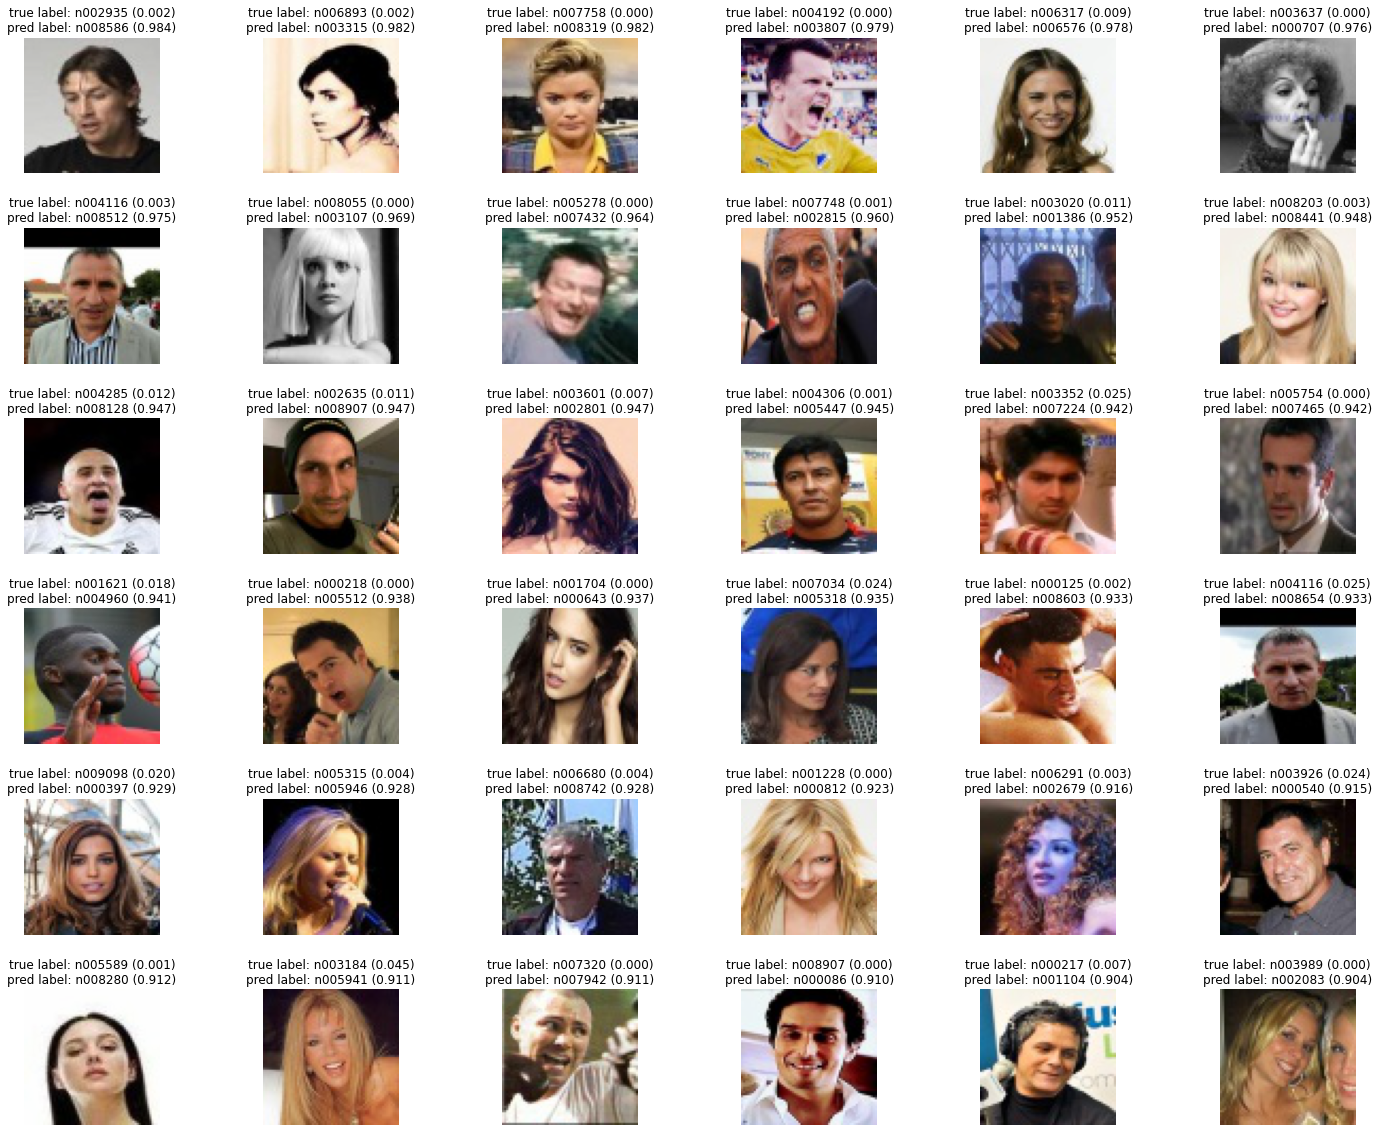

In [26]:
# plotting some of incorrect images
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

In [27]:
from torch.utils.data import Dataset, DataLoader

class VerificationDataset(Dataset):
    def __init__(self, file_list1,file_list2):
        self.file_list1 = file_list1
        self.file_list2 = file_list2

    def __len__(self):
        return len(self.file_list1)

    def __getitem__(self, index):
        img1 = Image.open(self.file_list1[index])
        img1 = torchvision.transforms.ToTensor()(img1)
        img2 = Image.open(self.file_list2[index])
        img2 = torchvision.transforms.ToTensor()(img2)
        return img1,img2


In [29]:
ver_file = open("C:/Users/malji/Datasets/HW4_Data/verification_pairs_val.txt","r").read().split('\n')

In [30]:
ver_col1 = []
ver_col2 = []
ver_labels = []

for i in range(len(ver_file)-1):
     
      p = ver_file[i].split()

      ver_col1.append('C:/Users/malji/Datasets/HW4_Data/'+p[0]) 
      ver_col2.append('C:/Users/malji/Datasets/HW4_Data/'+p[1]) 
      ver_labels.append(int(p[2]))


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch import nn, optim

import torchvision   
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [32]:
ver_set = VerificationDataset(ver_col1,ver_col2)
ver_loader = DataLoader(ver_set, batch_size=10, shuffle=False, drop_last=False)


In [33]:
model = ResNet(resnet18_config, 4000)

checkpoint = torch.load('C:/Users/malji/Google Drive/Colab Notebooks/trained_model/trained_model_4_3.t7')
model.load_state_dict(checkpoint['model_state_dict'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print()

In [41]:
model.to('cpu')
device = 'cpu'
from sklearn.decomposition import KernelPCA
import sklearn
from PIL import Image
model.fc = nn.Sequential()

dist=[]
with torch.no_grad():

  model.eval()
  for batch_num, (feats1,feats2) in enumerate(ver_loader):

    feats1 = feats1.to(device)
    feats2 = feats2.to(device)
    
    output1 = model(feats1)[0]
    output2 = model(feats2)[0]
    embed_train = np.concatenate((output1.cpu(), output2.cpu()), axis=0)
    pca_model = KernelPCA(n_components=100,kernel='cosine',n_jobs=-1)
    pca_model.fit(embed_train)
    embed1 = pca_model.transform(output1.cpu())
    embed2 = pca_model.transform(output2.cpu())
    
    for i in range(embed1.shape[0]):

      dist2 = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embed1[i], axis=0),np.expand_dims(embed2[i], axis=0))
      
      dist.append(dist2[0][0])


In [42]:
roc = sklearn.metrics.roc_auc_score(ver_labels, dist)

In [43]:
print("verification acc. = %", roc*100)

verification acc. = % 90.45490042246578
